In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

Epoch 1/50
138/138 [==============================] - 1s 2ms/step - loss: 0.0784 - val_loss: 0.0426
Epoch 2/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0257
Epoch 3/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0213 - val_loss: 0.0177
Epoch 4/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0153 - val_loss: 0.0134
Epoch 5/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0107
Epoch 6/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 7/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 8/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 9/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 10/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0045

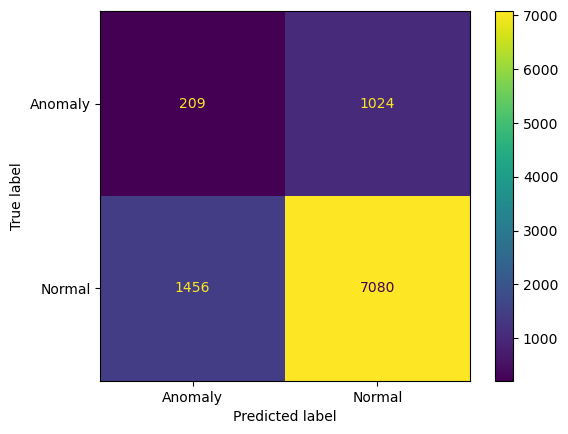

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def complete_anomaly_detection_system():
    # Load and preprocess data
    data = pd.read_csv('adultdata.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop('Sex', axis=1)
    
    X = data.drop('fnlwgt', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['fnlwgt']
    
    y = np.where(y_cont > 80000, 1, 0)  # Define `threshold` based on your domain knowledge
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    #data.info()


    data.dropna(axis=0, inplace=True)
    

    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    
    
    
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Define and train the autoencoder
    input_dim = X_train.shape[1]
    encoding_dim = 32
    input_layer = tf.keras.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', 
                           activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = models.Model(input_layer, decoded)
    encoder = models.Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)

    # Encode the data
    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)
    
    # Train XGBoost on the encoded data
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_train_encoded, y_train)
    
    # Predict with XGBoost to filter normal data
    xgb_predictions_train = xgb.predict(X_train_encoded)
    normal_indices = (xgb_predictions_train == 1)
    X_train_normal = X_train_encoded[normal_indices]
    
    # Train Isolation Forest on the filtered normal data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_normal)
    
    # Predict on the entire test dataset with Isolation Forest
    if_predictions = iso_forest.predict(X_test_encoded)
    if_predictions = np.where(if_predictions == 1, 1, 0)  # Convert predictions to binary
    
    # Evaluate the model
    precision = precision_score(y_test, if_predictions, pos_label=0)
    recall = recall_score(y_test, if_predictions, pos_label=0)
    f1 = f1_score(y_test, if_predictions, pos_label=0)
    
    
    print(classification_report(y_test, if_predictions))
    

    # Output the metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, if_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Example usage
# Ensure your CSV file is at the specified path and correctly formatted
complete_anomaly_detection_system()
